In [1]:
import pandas as pd

# Load only 'State' and minimal columns first to filter California rows
usecols = ['ID', 'Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng',
           'City', 'State', 'Weather_Condition', 'Humidity(%)', 'Visibility(mi)', 
           'Wind_Speed(mph)', 'Precipitation(in)']

# Load in chunks to avoid memory errors
chunksize = 500_000
cali_chunks = []

for chunk in pd.read_csv('US_Accidents_March23.csv', usecols=usecols, chunksize=chunksize):
    cali_chunk = chunk[chunk['State'] == 'CA']
    cali_chunks.append(cali_chunk)

# Combine all California chunks
df_ca = pd.concat(cali_chunks, ignore_index=True)

print(df_ca.shape)
print(df_ca.columns)

(1741433, 14)
Index(['ID', 'Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'End_Lat',
       'End_Lng', 'City', 'State', 'Humidity(%)', 'Visibility(mi)',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition'],
      dtype='object')


In [2]:
# Check missing data
print(df_ca.isnull().sum())

# Drop rows with missing location or time (critical)
df_ca = df_ca.dropna(subset=['Start_Lat', 'Start_Lng', 'Start_Time'])
print(f"Cleaned size: {df_ca.shape}")

ID                        0
Severity                  0
Start_Time                0
Start_Lat                 0
Start_Lng                 0
End_Lat              637331
End_Lng              637331
City                     11
State                     0
Humidity(%)           48341
Visibility(mi)        40125
Wind_Speed(mph)      162891
Precipitation(in)    566204
Weather_Condition     39778
dtype: int64
Cleaned size: (1741433, 14)


In [3]:
# Parse Start_Time
df_ca['Start_Time'] = pd.to_datetime(df_ca['Start_Time'], errors='coerce')

In [4]:
df_ca['Hour'] = df_ca['Start_Time'].dt.hour
df_ca['Rush_Hour_Flag'] = df_ca['Hour'].apply(lambda x: 1 if 7 <= x <= 9 or 16 <= x <= 18 else 0)

In [5]:
high_risk_weather = ['Heavy Snow', 'Thunderstorm', 'Blowing Dust', 'Heavy Rain', 'Fog']
df_ca['High_Risk_Weather_Flag'] = df_ca['Weather_Condition'].isin(high_risk_weather).astype(int)

In [6]:
city_counts = df_ca['City'].value_counts()
print(city_counts.head(15))

City
Los Angeles       156491
Sacramento         66264
San Diego          55504
San Jose           34531
Riverside          26317
Oakland            23571
San Bernardino     21990
Bakersfield        21390
Anaheim            21293
Long Beach         21040
Corona             18953
Ontario            18547
San Francisco      17775
Fresno             17185
Whittier           16518
Name: count, dtype: int64


In [7]:
cities = ['Los Angeles', 'San Francisco', 'San Diego', 'Sacramento', 'San Jose']

In [4]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import random
from shapely.geometry import Point

city_points = {}

def process_city(city_name, df_ca, radius=500):
    print(f"🚗 Processing city: {city_name}")

    # Subset accidents in this city
    df_city = df_ca[df_ca['City'].str.lower() == city_name.lower()]
    if df_city.empty:
        print(f"⚠️ No data for {city_name}")
        return

    # Get OSM graph around city's center
    location_point = (df_city['Start_Lat'].mean(), df_city['Start_Lng'].mean())
    print("Downloading OSM graph...")
    G = ox.graph_from_point(location_point, dist=radius, network_type='drive')

    # Add risk weights based on nearby accidents
    print("Tagging edges with risk score...")
    for u, v, k, data in G.edges(keys=True, data=True):
        # Skip if no geometry available
        if 'geometry' not in data:
            continue
        geom = data['geometry']

        # Check accidents within ~30 meters of this edge
        def is_near(row):
            accident_point = Point(row['Start_Lng'], row['Start_Lat'])
            return geom.distance(accident_point) < 0.0003

        nearby = df_city.apply(is_near, axis=1)
        accident_count = nearby.sum()

        # Risk weight: normalized accident count
        risk = 1 + (accident_count / 5)
        data['risk_weight'] = data['length'] * risk

    # Pick 2 random points in the graph
    nodes = list(G.nodes)
    if len(nodes) < 2:
        print("⚠️ Not enough nodes to calculate routes.")
        return
    point_a, point_b = random.sample(nodes, 2)
    city_points[city_name] = (point_a, point_b)  
    print(f"Selected Points -> Origin: {point_a}, Destination: {point_b}")

    # Shortest path (by distance)
    shortest = nx.shortest_path(G, point_a, point_b, weight='length')

    # Safest path (by risk_weight)
    safest = nx.shortest_path(G, point_a, point_b, weight='risk_weight')

    # Plot both routes
    fig, ax = ox.plot_graph_routes(
        G, [shortest, safest],
        route_colors=['blue', 'green'],
        route_linewidth=4,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False
    )

    # Add start and end markers
    x_a, y_a = G.nodes[point_a]['x'], G.nodes[point_a]['y']
    x_b, y_b = G.nodes[point_b]['x'], G.nodes[point_b]['y']
    ax.scatter([x_a], [y_a], c='red', s=100, label='Start')
    ax.scatter([x_b], [y_b], c='orange', s=100, label='End')
    ax.legend()

    plt.title(f"{city_name}: Shortest (Blue) vs Safest (Green)")
    plt.show()

🚗 Processing city: Los Angeles
Tagging edges with risk score...
Selected Points -> Origin: 6813513564, Destination: 2193435044


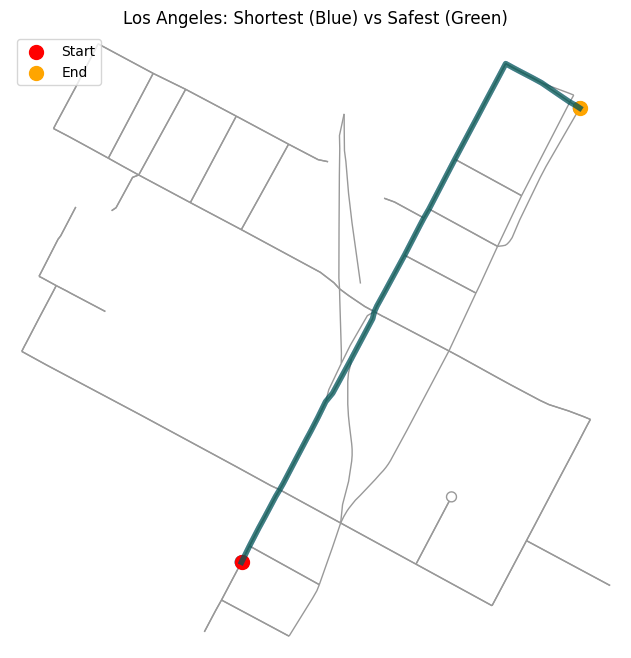

🚗 Processing city: San Francisco
Tagging edges with risk score...
Selected Points -> Origin: 65290928, Destination: 65317784


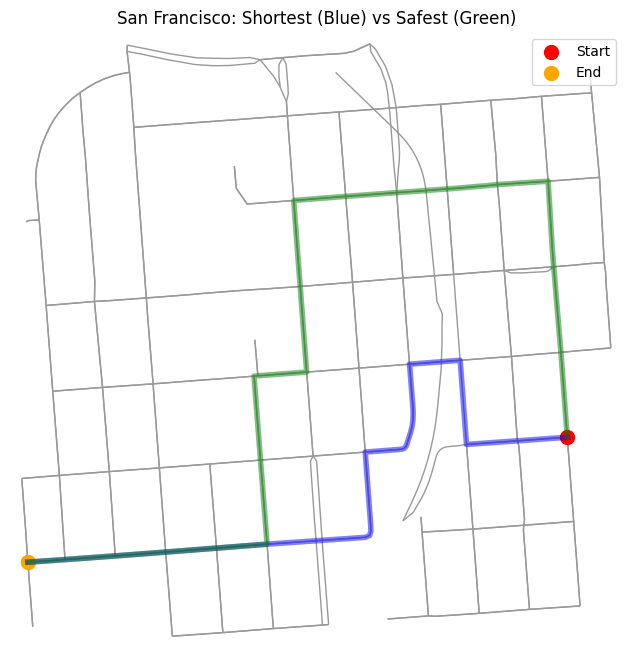

🚗 Processing city: San Diego
Tagging edges with risk score...
Selected Points -> Origin: 49528098, Destination: 49141811


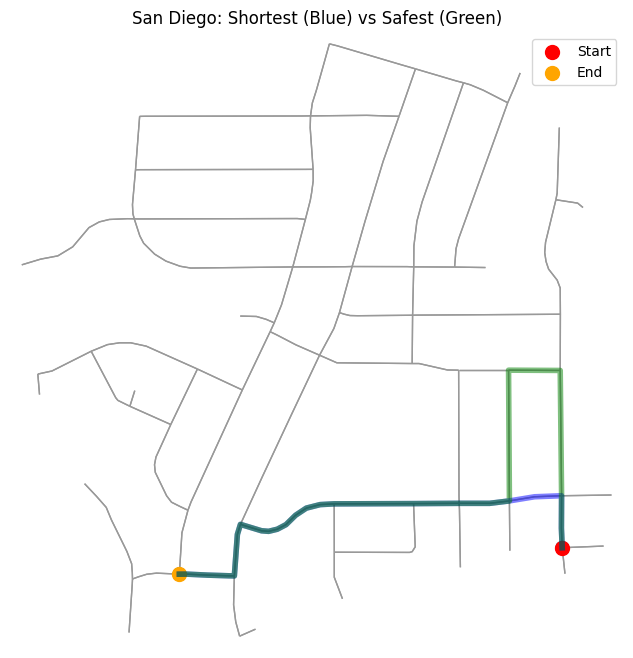

🚗 Processing city: Sacramento
Tagging edges with risk score...
Selected Points -> Origin: 90516456, Destination: 90516452


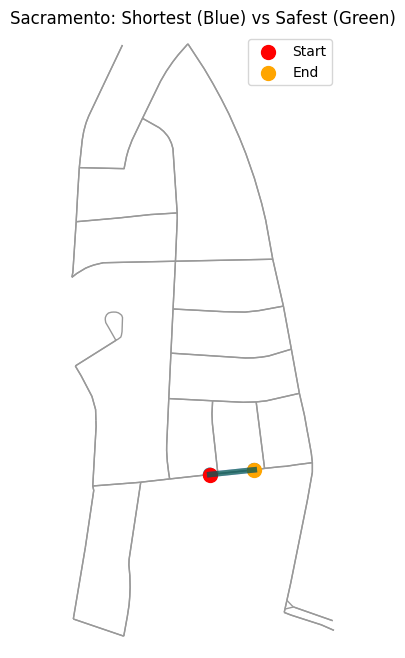

🚗 Processing city: Fresno
Tagging edges with risk score...
Selected Points -> Origin: 9577847389, Destination: 87501059


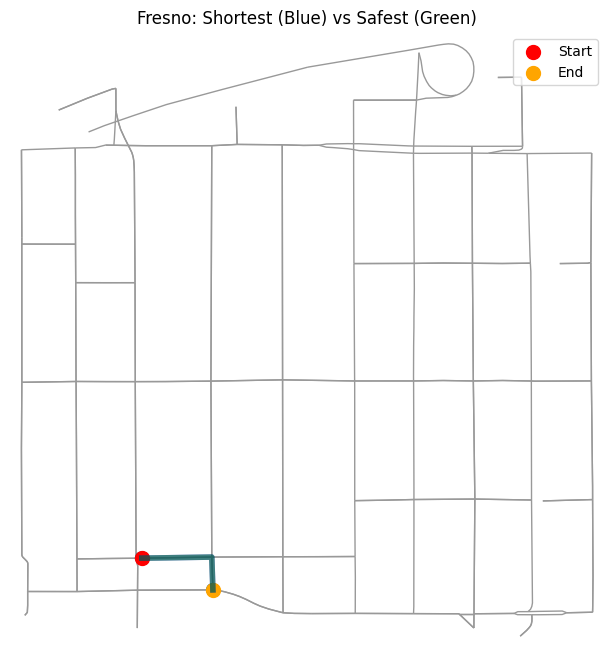

In [8]:
cities = ['Los Angeles', 'San Francisco', 'San Diego', 'Sacramento', 'Fresno']

for city in cities:
    process_city(city, df_ca)

In [9]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import random
from shapely.geometry import Point

def process_city(city_name, df_ca, radius=500):
    print(f"\n🚗 Processing city: {city_name}")

    # Subset accidents in this city
    df_city = df_ca[df_ca['City'].str.lower() == city_name.lower()]
    if df_city.empty:
        print(f"No data for {city_name} 🚫")
        return

    # Get OSM graph around the city's center
    location_point = (df_city['Start_Lat'].mean(), df_city['Start_Lng'].mean())
    print("Downloading OSM graph...")
    G = ox.graph_from_point(location_point, dist=radius, network_type='drive')

    # Add risk weights based on nearby accidents (using severity + weather)
    print("Tagging edges with complex risk score...")

    # Define bad weather keywords
    bad_weather_keywords = ['Rain', 'Fog', 'Snow', 'Thunderstorm', 'Sleet']

    for u, v, k, data in G.edges(keys=True, data=True):
        geom = data.get('geometry')
        if geom is None:
            continue  # skip if no geometry

        # Find accidents within ~30 meters of this road segment
        def calc_risk(row):
            accident_point = Point(row['Start_Lng'], row['Start_Lat'])
            if geom.distance(accident_point) < 0.0003:  # ~30m buffer
                severity = row.get('Severity', 1)
                weather = str(row.get('Weather_Condition', '')).lower()
                # Check for bad weather
                weather_factor = 1.0
                for kw in bad_weather_keywords:
                    if kw.lower() in weather:
                        weather_factor = 1.5  # increase risk if bad weather
                        break
                return severity * weather_factor
            else:
                return 0

        # Apply to all accidents in the city
        df_city = df_city.dropna(subset=['Start_Lat', 'Start_Lng'])  # ensure valid points
        nearby_risk = df_city.apply(calc_risk, axis=1)
        total_risk = nearby_risk.sum()  # total risk score for this edge

        # Final risk multiplier: normalized
        risk_multiplier = 1 + (total_risk / 10)  # /10 to keep scaling reasonable

        # Assign the risk_weight
        data['risk_weight'] = data['length'] * risk_multiplier

    # Using same 2 points in the graph to route between
    nodes = list(G.nodes)
    point_a, point_b = city_points[city_name]
    
    # Calculate shortest route (by length)
    shortest = nx.shortest_path(G, point_a, point_b, weight='length')

    # Calculate safest route (by risk_weight)
    safest = nx.shortest_path(G, point_a, point_b, weight='risk_weight')

    # Plot the routes
    fig, ax = ox.plot_graph_routes(
        G, [shortest, safest],
        route_colors=['blue', 'green'],
        route_linewidth=4,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False
    )

    # Mark start (green) and end (red)
    x_a, y_a = G.nodes[point_a]['x'], G.nodes[point_a]['y']
    x_b, y_b = G.nodes[point_b]['x'], G.nodes[point_b]['y']
    ax.scatter([x_a], [y_a], c='red', s=100, label='Start')
    ax.scatter([x_b], [y_b], c='orange', s=100, label='End')

    ax.legend()
    plt.title(f"{city_name}: Shortest (Blue) vs Safest (Green)")
    plt.show()


🚗 Processing city: Los Angeles
Tagging edges with complex risk score...


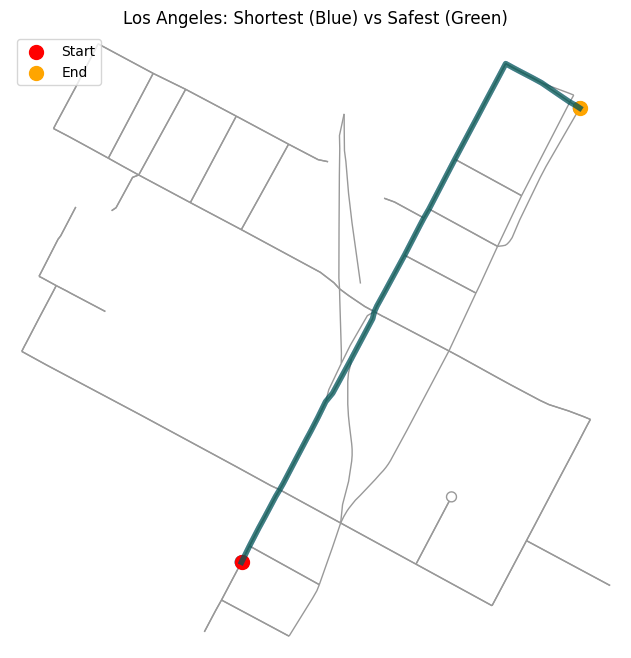


🚗 Processing city: San Francisco
Tagging edges with complex risk score...


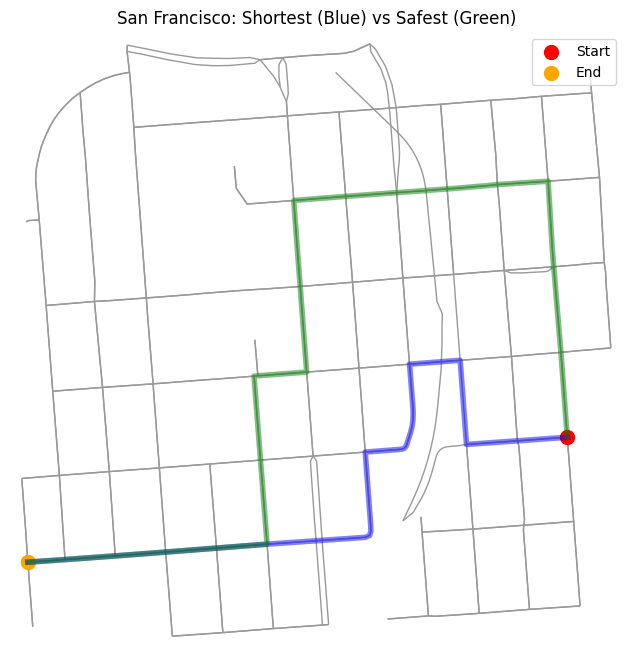


🚗 Processing city: San Diego
Tagging edges with complex risk score...


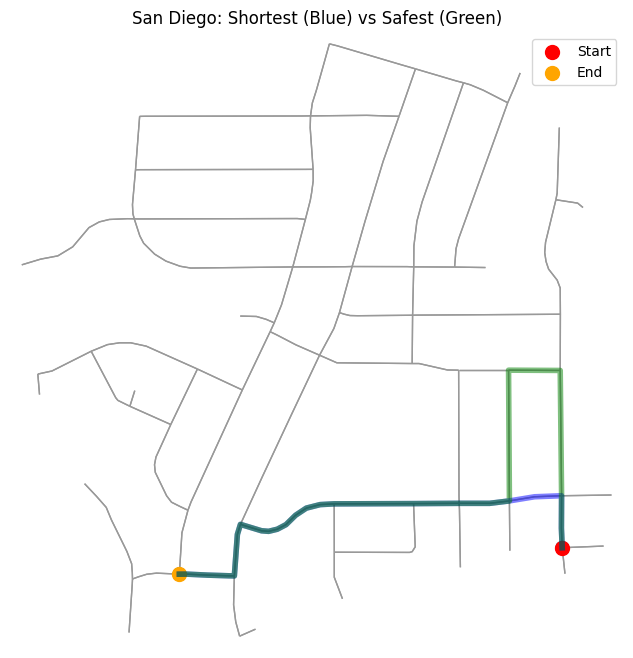


🚗 Processing city: Sacramento
Tagging edges with complex risk score...


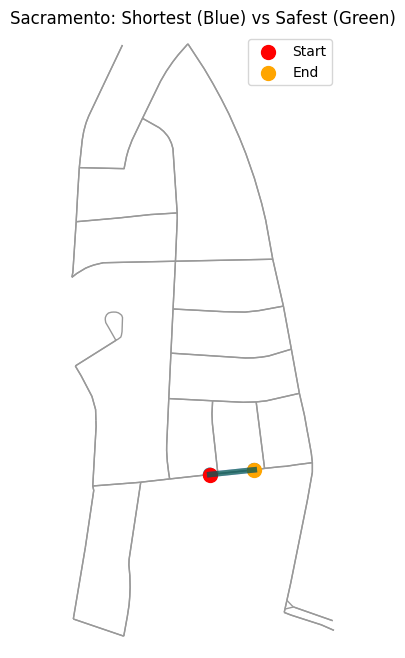


🚗 Processing city: Fresno
Tagging edges with complex risk score...


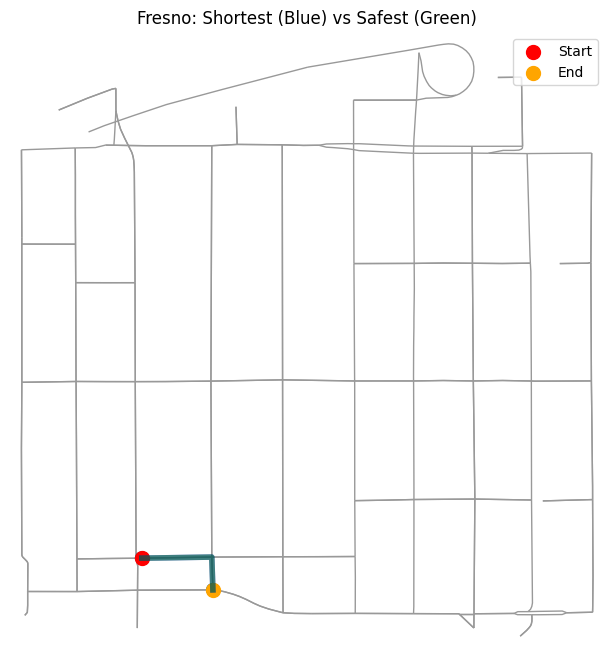

In [10]:
cities = ['Los Angeles', 'San Francisco', 'San Diego', 'Sacramento', 'Fresno']

for city in cities:
    process_city(city, df_ca)

In [12]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import random
from shapely.geometry import Point

def process_city(city_name, df_ca, radius=500):
    print(f"\n🚗 Processing city: {city_name}")

    # Subset accidents in this city
    df_city = df_ca[df_ca['City'].str.lower() == city_name.lower()]
    if df_city.empty:
        print(f"No data for {city_name} 🚫")
        return

    # Get OSM graph around the city's center
    location_point = (df_city['Start_Lat'].mean(), df_city['Start_Lng'].mean())
    print("Downloading OSM graph...")
    G = ox.graph_from_point(location_point, dist=radius, network_type='drive')

    # Add risk weights based on nearby accidents (using severity + weather)
    print("Tagging edges with complex risk score...")

    # Define bad weather keywords
    bad_weather_keywords = ['Rain', 'Fog', 'Snow', 'Thunderstorm', 'Sleet']

    for u, v, k, data in G.edges(keys=True, data=True):
        geom = data.get('geometry')
        if geom is None:
            continue  # skip if no geometry

        # Find accidents within ~30 meters of this road segment
        def calc_risk(row):
            accident_point = Point(row['Start_Lng'], row['Start_Lat'])
            if geom.distance(accident_point) < 0.0003:  # ~30m buffer
                severity = row.get('Severity', 1)
                weather = str(row.get('Weather_Condition', '')).lower()
                # Check for bad weather
                weather_factor = 1.0
                for kw in bad_weather_keywords:
                    if kw.lower() in weather:
                        weather_factor = 1.5  # increase risk if bad weather
                        break
                return severity * weather_factor
            else:
                return 0

        # Apply to all accidents in the city
        df_city = df_city.dropna(subset=['Start_Lat', 'Start_Lng'])  # ensure valid points
        nearby_risk = df_city.apply(calc_risk, axis=1)
        total_risk = nearby_risk.sum()  # total risk score for this edge

        # Final risk multiplier: normalized
        risk_multiplier = 1 + (total_risk / 10)  # /10 to keep scaling reasonable

        # Assign the risk_weight
        data['risk_weight'] = data['length'] * risk_multiplier

    # Using same 2 points in the graph to route between
    nodes = list(G.nodes)
    point_a, point_b = random.sample(nodes, 2)
    
    # Calculate shortest route (by length)
    shortest = nx.shortest_path(G, point_a, point_b, weight='length')

    # Calculate safest route (by risk_weight)
    safest = nx.shortest_path(G, point_a, point_b, weight='risk_weight')

    # Plot the routes
    fig, ax = ox.plot_graph_routes(
        G, [shortest, safest],
        route_colors=['blue', 'green'],
        route_linewidth=4,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False
    )

    # Mark start (green) and end (red)
    x_a, y_a = G.nodes[point_a]['x'], G.nodes[point_a]['y']
    x_b, y_b = G.nodes[point_b]['x'], G.nodes[point_b]['y']
    ax.scatter([x_a], [y_a], c='red', s=100, label='Start')
    ax.scatter([x_b], [y_b], c='orange', s=100, label='End')

    ax.legend()
    plt.title(f"{city_name}: Shortest (Blue) vs Safest (Green)")
    plt.show()


🚗 Processing city: Los Angeles
Tagging edges with complex risk score...


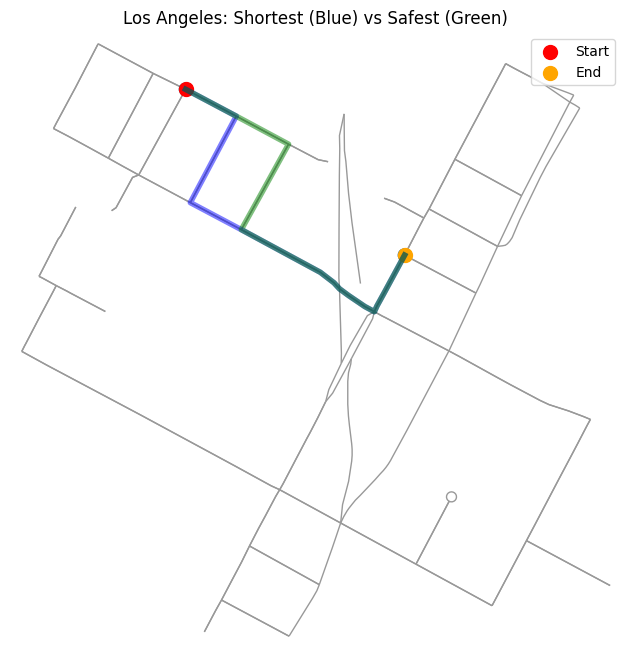


🚗 Processing city: San Francisco
Tagging edges with complex risk score...


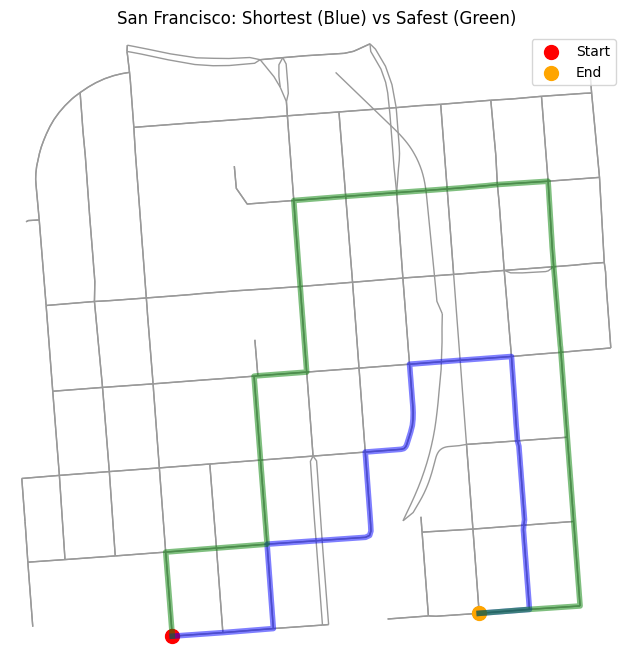


🚗 Processing city: San Diego
Tagging edges with complex risk score...


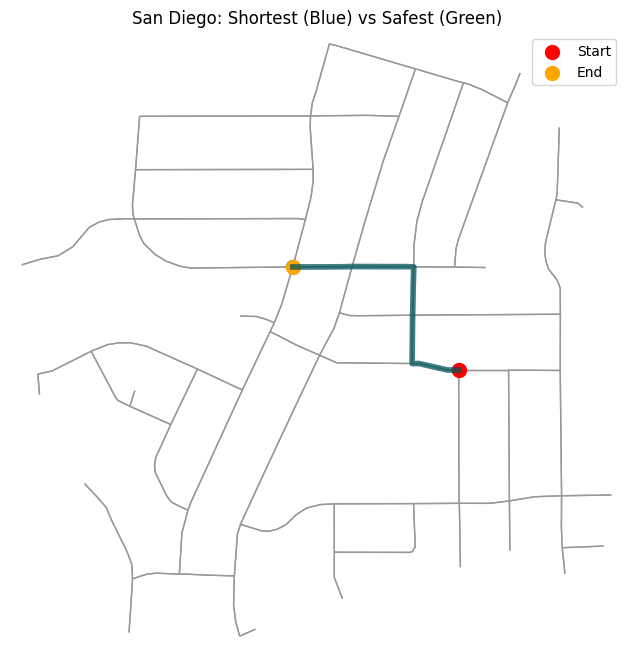


🚗 Processing city: Sacramento
Tagging edges with complex risk score...


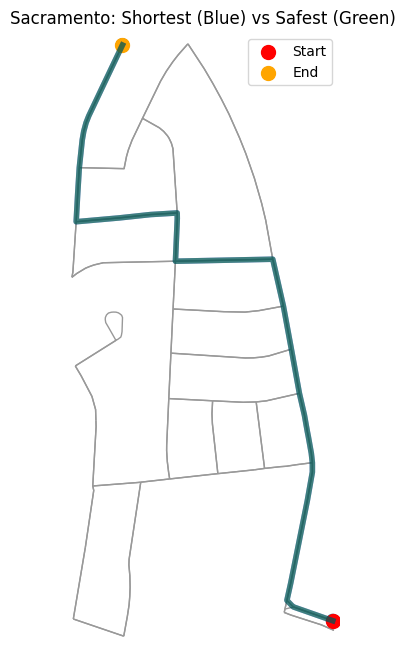


🚗 Processing city: Fresno
Tagging edges with complex risk score...


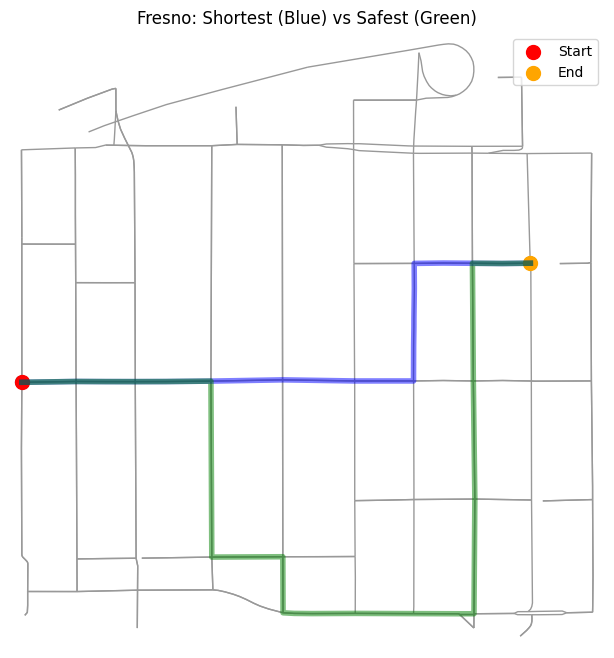

In [13]:
cities = ['Los Angeles', 'San Francisco', 'San Diego', 'Sacramento', 'Fresno']

for city in cities:
    process_city(city, df_ca)